<a href="https://colab.research.google.com/github/Radium2000/p760-cpbonn-wolff/blob/main/Isingwolff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numba import jit, prange
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
import numpy as np

plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
@jit(nopython=True)
def init_config(N):

  return np.random.choice(np.array([-1,1]),size=(N,N))
@jit(nopython=True)
def nrg(config):
  N = config.shape[0]
  enrg = 0
  
  for i in prange(N):
    for j in prange(N):

      nn = config[(i-1)%N, j] + config[(i+1)%N, j] + config[i, (j-1)%N] + config[i, (j+1)%N]
      enrg -=  config[i,j] * nn

  return enrg / 2 


@jit(nopython=True)
def MC(config, beta):
 
  N = config.shape[0]

  for n in prange(N**2):

      i, j = np.random.randint(N), np.random.randint(N)

      nn = config[(i-1)%N, j] + config[(i+1)%N, j] + config[i, (j-1)%N] + config[i, (j+1)%N] 
      
      delta = 2 * config[i,j] * nn

      if delta < 0 or np.random.random() < np.exp(- beta * delta):
        config[i,j] = -1. * config[i,j]
        
  return config  

@jit(nopython = True)
def add(config, beta, starting, cluster):
    
    L = config.shape[0] 
    N = L**2
    
    p_add = 1. - np.exp(-2*beta) 
    
    i, j = starting[0], starting[1] 
    
    nbr = np.array([ [(i - 1)%L, j], [(i + 1)%L, j], [i, (j - 1)%L], [i, (j + 1)%L] ])
    
    starting_spin = config[i, j]
    
    new_elements = []
    
    for n in nbr:
        if config[n[0], n[1]] == starting_spin and [n[0], n[1]] not in cluster \
        and np.random.uniform(0., 1.) < p_add:
        
            new_elements.append([n[0], n[1]])
            
    cluster += new_elements
    
    return cluster

@jit(nopython = True)
def wolff(config, beta):
    
    L = config.shape[0] 
    N = L**2
        
    i, j = np.random.randint(L), np.random.randint(L)
    
    cluster = [[i,j]] 
        
    for elem in cluster:
        cluster = add(config, beta, elem, cluster)
        
    for elem in cluster:
        config[elem[0], elem[1]] *= -1
        
    return config

def Ising2d(N, beta, eq_steps = int(1e4), steps = int(1e6), order = False, annealing = False, cluster = True, verbose=True):
    
    if verbose:
        print('N:', N, ', beta:', beta, ', cluster:', cluster, ', annealing:', annealing , '\n')


    if order:
        curr_config = np.ones((N,N))
    else:
        curr_config = init_config(N)

    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
  
    if annealing:
        betas = np.zeros(eq_steps)
        N_annealing = eq_steps-eq_steps//10
        betas[:N_annealing] = np.linspace(0.1, beta, num=N_annealing, endpoint=True)
        betas[N_annealing:] = beta
    else:
        betas = np.zeros(eq_steps) + beta
      
    if verbose:
        for i in tqdm(range(eq_steps)):
            E_eq[i] = nrg(curr_config)
            M_eq[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, betas[i])         
            else:
                curr_config = MC(curr_config, betas[i])

    
    else:
        for i in range(eq_steps):
            E_eq[i] = nrg(curr_config)
            M_eq[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, betas[i])         
            else:
                curr_config = MC(curr_config, betas[i])
        
    if verbose:  
        print('Start')

    E = np.zeros(steps)
    M = np.zeros(steps)
  
    if verbose:
        for i in tqdm(range(steps)):
            E[i] = nrg(curr_config)
            M[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, beta)
            else:
                curr_config = MC(curr_config, beta)
        print('End')
    
    else:
        for i in range(steps):
            E[i] = nrg(curr_config)
            M[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, beta)
            else:
                curr_config = MC(curr_config, beta)

    E_mean, M_mean, C, Chi = np.mean(E), np.mean(M), beta**2*np.std(E)**2, beta*np.std(M)**2
    E_var, M_var = np.std(E), np.std(M)
    M4, M2 = np.mean(M**4), np.mean(M**2)
    BC = 1 - (M4/(3*(M2**2)))

    return (E_mean, M_mean, C, Chi,E_var, M_var,E_eq, M_eq, E, M, BC) 

In [ ]:
N_T = 40
Ts = np.linspace(1.00, 3.50, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [10,15,20,25,30]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
Cs = np.zeros((N_N, N_T))
Chis = np.zeros((N_N, N_T))
BCs = np.zeros((N_N, N_T))

for i,N in enumerate(Ns):
  print('Simulating N={}'.format(N))
  for j, beta in enumerate(tqdm(betas)):
    #print('\t{}/{}  beta: {}'.format(j,N_T,beta))
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M, BC, = Ising2d( N, beta, eq_steps=eq_steps, steps=steps, annealing=False, cluster=False,verbose=False  )

    Es[i,j] = E_mean
    Ms[i,j] = M_mean
    Cs[i,j] = C_mean
    Chis[i,j] = Chi_mean
    BCs[i,j] = BC

Simulating N=10


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=15


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=20


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=25


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=30


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
N_T = 40
Ts = np.linspace(1.00, 3.50, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [40,50,60,70]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
Cs = np.zeros((N_N, N_T))
Chis = np.zeros((N_N, N_T))
BCs = np.zeros((N_N, N_T))

for i,N in enumerate(Ns):
  print('Simulating N={}'.format(N))
  for j, beta in enumerate(tqdm(betas)):
    #print('\t{}/{}  beta: {}'.format(j,N_T,beta))
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M, BC, = Ising2d( N, beta, eq_steps=eq_steps, steps=steps, annealing=True, cluster=False,verbose=False  )

    Es[i,j] = E_mean
    Ms[i,j] = M_mean
    Cs[i,j] = C_mean
    Chis[i,j] = Chi_mean
    BCs[i,j] = BC

Simulating N=40


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=50


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=60


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=70


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
def plot_values (Es,Ms,Cs,Chis,N,startN=0,endN=BCs.shape[0]-1):
    titles=['Energy (E)','Magnetisation (M)','Specific Heat ($C_v$)','Susceptibility']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities=[Es,np.abs(Ms),Cs,Chis]
    plt.figure(figsize=(16,10))
    for i in range(len(physical_quantities)):
        ax=plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        #ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(startN,endN+1):
            ax.plot(Ts[1:], physical_quantities[i][j][1:] / N[j]**2, '.',markersize=9, label='N='+str(N[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

In [ ]:
plot_values(Es,Ms,Cs,Chis,Ns,startN=0)    

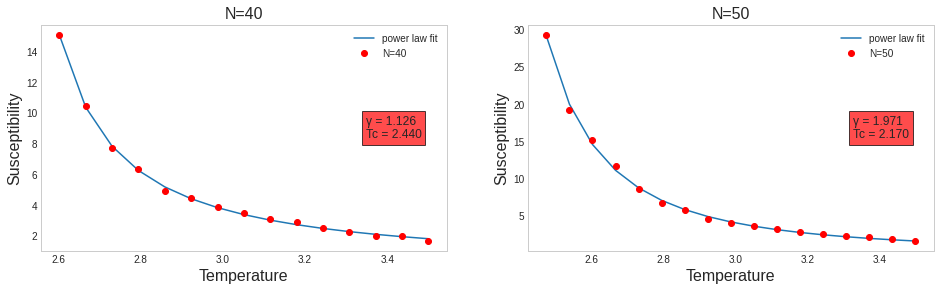

In [ ]:
def func_powerlaw(T, k=1, gamma=-1, Tc=2.26):
    return k * np.abs(T-Tc)**gamma
plt.style.use('seaborn-whitegrid')
N_T = 40
Ts = np.linspace(1.00, 3.50, endpoint=True, num=N_T)

tt = [8, 4, 4, 4, 5]
N = [40,50,60,70]
Ks = np.zeros(5)
gammas = np.zeros(5)
sigma_gamma = np.zeros(5)
TCs = np.zeros(5)
sigma_TCs = np.zeros(5)
col=['red','red','red','red', 'red']

plt.figure(figsize=(16,15))
for i, Chi in enumerate(Chis):
  ax=plt.subplot(3,2,i+1)

  Tmax = np.argmax(Chi[2:])
  sol,cov = curve_fit(func_powerlaw, Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, maxfev=int(1e6) )
  Ks[i] = sol[0]
  gammas[i] = sol[1]
  TCs[i] = sol[2]
  sigma_gamma[i] = cov[1,1]
  sigma_TCs[i] = cov[2,2]

  ax.plot(Ts[Tmax+tt[i]:], func_powerlaw(Ts[Tmax+tt[i]:], Ks[i], gammas[i], TCs[i]), label='power law fit')
  ax.plot(Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, 'o',color=col[i], label='N={}'.format(N[i])  )
  ax.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[i]),'%.3f'%TCs[i]), transform=ax.transAxes,bbox=dict(facecolor=col[i], alpha=0.7), fontsize=12)
  ax.set_xlabel('Temperature', fontsize = 16)
  ax.set_ylabel('Susceptibility', fontsize = 16)
  ax.set_title('N={}'.format(N[i]),  fontsize = 16)
  ax.xaxis.set_minor_locator(MultipleLocator(0.05))
  ax.yaxis.set_minor_locator(MultipleLocator(1))
  plt.legend()
  plt.grid()
  #print(gammas[i], TCs[i])

plt.subplots_adjust(hspace=0.3)  
plt.show()

In [ ]:
def func_powerlaw(T, k=1, gamma=-1, Tc=2.26):
    return k * np.abs(T-Tc)**gamma
plt.style.use('seaborn-whitegrid')
N_T = 40
Ts = np.linspace(1.00, 3.50, endpoint=True, num=N_T)

tt = [8, 4, 4, 4, 5]
N = [40,50,60,70]
Ks = np.zeros(5)
gammas = np.zeros(5)
sigma_gamma = np.zeros(5)
TCs = np.zeros(5)
sigma_TCs = np.zeros(5)
col=['red','red','red','red', 'red']

plt.figure(figsize=(16,15))
for i, Chi in enumerate(Ms):
  ax=plt.subplot(3,2,i+1)

  Tmax = np.argmax(Chi[2:])
  sol,cov = curve_fit(func_powerlaw, Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, maxfev=int(1e6) )
  Ks[i] = sol[0]
  gammas[i] = sol[1]
  TCs[i] = sol[2]
  sigma_gamma[i] = cov[1,1]
  sigma_TCs[i] = cov[2,2]

  ax.plot(Ts[Tmax+tt[i]:], func_powerlaw(Ts[Tmax+tt[i]:], Ks[i], gammas[i], TCs[i]), label='power law fit')
  ax.plot(Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, 'o',color=col[i], label='N={}'.format(N[i])  )
  ax.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[i]),'%.3f'%TCs[i]), transform=ax.transAxes,bbox=dict(facecolor=col[i], alpha=0.7), fontsize=12)
  ax.set_xlabel('Temperature', fontsize = 16)
  ax.set_ylabel('Susceptibility', fontsize = 16)
  ax.set_title('N={}'.format(N[i]),  fontsize = 16)
  ax.xaxis.set_minor_locator(MultipleLocator(0.05))
  ax.yaxis.set_minor_locator(MultipleLocator(1))
  plt.legend()
  plt.grid()
  #print(gammas[i], TCs[i])

plt.subplots_adjust(hspace=0.3)  
plt.show()

In [ ]:
def func_powerlaw(T, k=1, gamma=-1, Tc=2.26):
    return k * np.abs(T-Tc)**gamma
plt.style.use('seaborn-whitegrid')
N_T = 40
Ts = np.linspace(1.00, 3.50, endpoint=True, num=N_T)

tt = [8, 4, 4, 4, 5]
N = [40,50,60,70]
Ks = np.zeros(5)
gammas = np.zeros(5)
sigma_gamma = np.zeros(5)
TCs = np.zeros(5)
sigma_TCs = np.zeros(5)
col=['red','red','red','red', 'red']

plt.figure(figsize=(16,15))
for i, Chi in enumerate(Cs):
  ax=plt.subplot(3,2,i+1)

  Tmax = np.argmax(Chi[2:])
  sol,cov = curve_fit(func_powerlaw, Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, maxfev=int(1e6) )
  Ks[i] = sol[0]
  gammas[i] = sol[1]
  TCs[i] = sol[2]
  sigma_gamma[i] = cov[1,1]
  sigma_TCs[i] = cov[2,2]

  ax.plot(Ts[Tmax+tt[i]:], func_powerlaw(Ts[Tmax+tt[i]:], Ks[i], gammas[i], TCs[i]), label='power law fit')
  ax.plot(Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, 'o',color=col[i], label='N={}'.format(N[i])  )
  ax.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[i]),'%.3f'%TCs[i]), transform=ax.transAxes,bbox=dict(facecolor=col[i], alpha=0.7), fontsize=12)
  ax.set_xlabel('Temperature', fontsize = 16)
  ax.set_ylabel('Susceptibility', fontsize = 16)
  ax.set_title('N={}'.format(N[i]),  fontsize = 16)
  ax.xaxis.set_minor_locator(MultipleLocator(0.05))
  ax.yaxis.set_minor_locator(MultipleLocator(1))
  plt.legend()
  plt.grid()
  #print(gammas[i], TCs[i])

plt.subplots_adjust(hspace=0.3)  
plt.show()

In [ ]:
gammas.mean()


-1.914140616303369

In [ ]:
TCs.mean()

2.1326088795524987

In [ ]:
N = 10
T=0.25
beta = 1/T

n_simulation=2

M_Ts=[]
for i in range(n_simulation):
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_t, BC  = Ising2d(N, beta, eq_steps=int(1e4), steps=int(1e4), annealing=True)
    M_Ts.append(M_t)
    

plt.figure(figsize=(16,5))

for i in range(n_simulation):    
    ax0=plt.subplot(1,n_simulation,i+1)
    ax0.set_ylim([-1.2, 1.2])
    ax0.plot(M_Ts[i] / N**2, color='blue', label='T<Tc')
    ax0.set_title(r'Magnetisation vs step ($\beta$ = 4)', fontsize = 20, fontweight = "bold" )
    ax0.set_ylabel('Magnetisation', fontsize=16)
    ax0.set_xlabel('Step', fontsize=16)
    ax0.grid()
    ax0.legend(fontsize=12)

plt.show()

plt.figure(figsize=(16,5))
for i in range(n_simulation):
    ax=plt.subplot(1,n_simulation,i+1)
    ax.set_xlim([-1.2, 1.2])
    ax.hist(M_Ts[i] / N**2, align='mid', ec='black', bins=10, color='blue')
    ax.set_title(r'Magnetisation distribution ($\beta$ = 4)', fontsize = 20, fontweight = "bold" )
    ax.set_ylabel('Counts', fontsize=16)
    ax.set_xlabel('Magnetisation', fontsize=16)
plt.show()

In [ ]:
#--- Computing τ for different TEMPERATURES -----------
N = 60
eq_steps = int(1e4)
steps = int(1e3)


Tc= 2 / np.log(1 + np.sqrt(2))
Ts = np.array([Tc-0.5, Tc, Tc+0.5])
N_T = len(Ts)
betas = 1 / Ts

Eeq_s_t = np.zeros((N_T,eq_steps))
Meq_s_t = np.zeros((N_T,eq_steps))
Es_t = np.zeros((N_T, steps))
Ms_t = np.zeros((N_T, steps))

for i, beta in enumerate(betas):
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq_t, M_eq_t, E_t, M_t, BC = Ising2d(N, beta, eq_steps=eq_steps, steps=steps)

    Eeq_s_t[i] = E_eq_t
    Meq_s_t[i] = M_eq_t
    Es_t[i] = E_t
    Ms_t[i] = M_t

corr_varT = []
num_lag=200

for i, T in enumerate(Ts):
    tmp = acf(Ms_t[i], nlags=num_lag, fft=False)
    corr_varT.append(tmp)


---------- ISING MODEL ----------
N: 60 , beta: 0.5652319132237569 , cluster: True , annealing: False 

Start equilibration...


  0%|          | 0/10000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/1000 [00:00<?, ?it/s]

End simulation...
---------- ISING MODEL ----------
N: 60 , beta: 0.44068679350977147 , cluster: True , annealing: False 

Start equilibration...


  0%|          | 0/10000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/1000 [00:00<?, ?it/s]

End simulation...
---------- ISING MODEL ----------
N: 60 , beta: 0.36111703859883826 , cluster: True , annealing: False 

Start equilibration...


  0%|          | 0/10000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/1000 [00:00<?, ?it/s]

End simulation...


In [ ]:
def func(x, m, q):
    return m*x + q

end_step=4
lag = np.arange(len(corr_varT[0][:end_step+1]))
tau_list=[]
parameters=[]
for i,temp in enumerate(corr_varT):
    t=np.arange(0,end_step+1)
    sol, err = curve_fit(func, lag, np.log(corr_varT[i][:end_step+1]) )
    tau_list.append(-1/sol[0])
    parameters.append(sol)


plt.figure(figsize=(12,6))
ax2=plt.subplot(1,1,1)
for i,x in enumerate(corr_varT):
    ax2.plot(np.log(x[:end_step+1]),'o', label='T='+str('%.3f'%Ts[i]))
    ax2.plot( (parameters[i][0])*(np.arange(end_step+1)) + parameters[i][1] , '-', label='fit (T={})'.format('%.3f'%Ts[i]))
ax2.set_xlabel('lag time')
ax2.set_ylabel('log( Autocorrelation function )')
ax2.set_title('Autocorrelation Function (log scale) vs Lag Time', fontsize = 18, fontweight = "bold" )
ax2.xaxis.set_minor_locator(MultipleLocator(0.25))
ax2.grid()
ax2.legend()
plt.show()

print('\nThe values of τ for each temperature is: ')
for i,temp in enumerate(Ts):
  print('\n\tT={} ---> τ={}'.format('%.3f'%temp, '%.3f'%tau_list[i]))

In [ ]:

N_n = np.arange(50,151,50)
N_N=len(N_n)

eq_steps = int(5e2)
steps = int(5e2)

Tc= 2 / np.log(1 + np.sqrt(2))
beta = 1 / Tc

Eeq_s_n = np.zeros((N_N,eq_steps))
Meq_s_n = np.zeros((N_N,eq_steps))
Es_n = np.zeros((N_N, steps))
Ms_n = np.zeros((N_N, steps))

for i, n in enumerate(N_n):
  E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq_n, M_eq_n, E_n, M_n, BC  = Ising2d(n, beta, eq_steps=eq_steps, steps=steps)

  Eeq_s_n[i] = E_eq_n
  Meq_s_n[i] = M_eq_n
  Es_n[i] = E_n
  Ms_n[i] = M_n

corr_varN2 = []
num_lag=600
for i, n in enumerate(N_n):
  
    tmp = acf(Ms_n[i], nlags=num_lag, fft=False)
    corr_varN2.append(tmp)

#--- Plot
plt.figure(figsize=(12,6))
ax3=plt.subplot(1,1,1)
for i,x in enumerate(corr_varN2):
    ax3.plot(x, label='N='+str(N_n[i]))

ax3.set_xlabel('lag time')
ax3.set_ylabel('Autocorrelation function')
ax3.set_title(' Autocorrelation Function vs Lag Time', fontsize = 18, fontweight = "bold" )
ax3.grid()
ax3.legend()
plt.show()

def func(x, m, q):
    return m*x + q

print('Characteristic time (τ) value: ')
end_step=20
lag2 = np.arange(len(corr_varT[0][:end_step+1]))
tau_list_2=[]
parameters_2=[]
for i,temp in enumerate(N_n):
    t=np.arange(0,end_step+1)
    sol2 = curve_fit(func, lag2, np.log(corr_varN2[i][:end_step+1]) )
    tau_list_2.append(-1/sol2[0][0])
    parameters_2.append(sol2[0])
    print('\n\tN={} ---> τ={}'.format('%.3f'%temp, '%.3f'%tau_list_2[i]))

In [ ]:
N = 40
beta = 1/2.269

# MCMC 
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_G  = Ising2d(N, beta, eq_steps=int(1e3), steps=int(1), cluster=False)

# Wolff  
E_mean_w, M_mean_w, C_mean_w, Chi_mean_w, E_var_w, M_var_w, E_eq_w, M_eq_w, E_w, M_G_w, BC  = Ising2d(N, beta, eq_steps=int(1e3), steps=int(1), cluster = True)



fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax0.plot(E_eq / N**2, 'red', label = r'T = $T_c$')
ax0.set_title('Energy ', fontsize = 20, fontweight = "bold")
ax0.set_xlabel('Step', fontsize=14)
ax0.set_ylabel('E/N', fontsize=14)
ax0.tick_params(axis="x",labelsize=14)
ax0.tick_params(axis="y",labelsize=14)
ax0.legend(loc='upper right', fontsize=14)
#ax0.set_xlim([-50, 300])

ax1.plot(E_eq_w / N**2, 'blue', label = r'T = $T_c$')
ax1.set_title('Energy with Wolff', fontsize = 20, fontweight = "bold")
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('E/N', fontsize=14)
ax1.tick_params(axis="x",labelsize=14)
ax1.tick_params(axis="y",labelsize=14)
ax1.legend(loc='upper right', fontsize=14)
#ax0.set_xlim([-50, 300])


fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax0.plot(M_eq / N**2, 'red', label = r'T = $T_c$')
ax0.set_title('Metropolis-Hastings', fontsize = 20, fontweight = "bold")
ax0.set_xlabel('Step', fontsize=14)
ax0.set_ylabel('M/N', fontsize=14)
ax0.tick_params(axis="x",labelsize=14)
ax0.tick_params(axis="y",labelsize=14)
ax0.legend(loc='upper right', fontsize=14)

ax1.plot(M_eq_w / N**2, 'blue', label = r'T = $T_c$')
ax1.set_title('Wolff cluster', fontsize = 20, fontweight = "bold")
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('M/N', fontsize=14)
ax1.tick_params(axis="x",labelsize=14)
ax1.tick_params(axis="y",labelsize=14)
ax1.legend(loc='upper right', fontsize=14)

plt.show()


In [ ]:

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax0.plot(E_eq / N**2, 'red')
ax0.set_title('Metropolis-Hastings(At T = $T_C$)', fontsize = 20, fontweight = "bold")
ax0.set_xlabel('Step', fontsize=14)
ax0.set_ylabel('E/N', fontsize=14)
ax0.tick_params(axis="x",labelsize=14)
ax0.tick_params(axis="y",labelsize=14)
ax0.legend(loc='upper right', fontsize=14)
#ax0.set_xlim([-50, 300])

ax1.plot(E_eq_w / N**2, 'red')
ax1.set_title('Energy with Wolff(At T = $T_C$)', fontsize = 20, fontweight = "bold")
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('E/N', fontsize=14)
ax1.tick_params(axis="x",labelsize=14)
ax1.tick_params(axis="y",labelsize=14)
ax1.legend(loc='upper right', fontsize=14)
#ax0.set_xlim([-50, 300])


fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax0.plot(M_eq / N**2, 'red')
ax0.set_title('Metropolis-Hastings(At T = $T_C$)', fontsize = 20, fontweight = "bold")
ax0.set_xlabel('Step', fontsize=14)
ax0.set_ylabel('M/N', fontsize=14)
ax0.tick_params(axis="x",labelsize=14)
ax0.tick_params(axis="y",labelsize=14)
ax0.legend(loc='upper right', fontsize=14)

ax1.plot(M_eq_w / N**2, 'red')
ax1.set_title('Wolff cluster(At T = $T_C$)', fontsize = 20, fontweight = "bold")
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('M/N', fontsize=14)
ax1.tick_params(axis="x",labelsize=14)
ax1.tick_params(axis="y",labelsize=14)
ax1.legend(loc='upper right', fontsize=14)

plt.show()


3d

In [ ]:


@jit(nopython=True)
def init_config(N):

  return np.random.choice(np.array([-1,1]),size=(N,N,N))

@jit(nopython=True)
def nrg(config):

  N = config.shape[0]
  nrg = 0
  for i in prange(N):
    for j in prange(N):
      for k in prange(N):
        nn = config[(i-1)%N, j, k] + config[(i+1)%N, j, k] + config[i, (j-1)%N, k] + config[i, (j+1)%N, k] + config[i, j, (k-1)%N] + config[i, j, (k+1)%N]
        nrg -=  config[i,j,k] * nn

  return nrg / 2 


@jit(nopython=True)
def MC(config, beta):
  N = config.shape[0]
  for n in prange(N**3):

      i, j, k = np.random.randint(N), np.random.randint(N), np.random.randint(N)

      nn = config[(i-1)%N, j, k] + config[(i+1)%N, j, k] + config[i, (j-1)%N, k] + config[i, (j+1)%N, k] + config[i, j, (k-1)%N] + config[i, j, (k+1)%N] 
      delta = 2 * config[i,j,k] * nn

      if delta < 0 or np.random.random() < np.exp(- beta * delta):
        config[i,j,k] = -1. * config[i,j,k]
        
  return config


@jit(nopython = True)
def add(config, beta, starting, cluster):
    
    L = config.shape[0] 
    N = L**3
    
    p_add = 1. - np.exp(-2*beta) 
    
    i, j, k = starting[0], starting[1], starting[2] 
    
    nbr = np.array([ [(i - 1)%L, j, k], [(i + 1)%L, j, k], [i, (j - 1)%L, k], [i, (j + 1)%L, k], [i, j, (k - 1)%L], [i, j, (k + 1)%L] ])
    
    starting_spin = config[i, j, k]
    
    new_elements = []
    
    for n in nbr:
       
        if config[n[0], n[1], n[2]] == starting_spin and [n[0], n[1], n[2]] not in cluster \
        and np.random.uniform(0., 1.) < p_add:
        
            new_elements.append([n[0], n[1], n[2]])
            
           
    cluster += new_elements
    
    return cluster

@jit(nopython = True)
def wolff(config, beta):
    
    
    L = config.shape[0] 
    N = L**3
        
    
    i, j, k = np.random.randint(L), np.random.randint(L), np.random.randint(L)
    
    
    cluster = [[i,j,k]] 
        
    
    for elem in cluster:
        cluster = add(config, beta, elem, cluster)
        
           
    for elem in cluster:
        config[elem[0], elem[1], elem[2]] *= -1
        
    return config

def Ising(N, beta, eq_steps = int(1e4), steps = int(1e6), order = False, annealing = False, cluster = True, verbose=True):

    
    if verbose:
        print('---------- ISING MODEL ----------')
        print('N:', N, ', beta:', beta, ', cluster:', cluster, ', annealing:', annealing , '\n')

        print('Start equilibration...')

    if order:
        curr_config= np.ones((N,N,N))
    else:
        curr_config = init_config(N)

    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
  
    if annealing:
        betas = np.zeros(eq_steps)
        N_annealing = eq_steps-eq_steps//10
        betas[:N_annealing] = np.linspace(0.1, beta, num=N_annealing, endpoint=True)
        betas[N_annealing:] = beta
    else:
        betas = np.zeros(eq_steps) + beta
      
    if verbose:
        for i in tqdm(range(eq_steps)):
            E_eq[i] = nrg(curr_config)
            M_eq[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, betas[i])         
            else:
                curr_config = MC(curr_config, betas[i])

    
    else:
        for i in range(eq_steps):
            E_eq[i] = nrg(curr_config)
            M_eq[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, betas[i])         
            else:
                curr_config = MC(curr_config, betas[i])
        
    if verbose:  
        print('')

    E = np.zeros(steps)
    M = np.zeros(steps)
  
    if verbose:
        for i in tqdm(range(steps)):
            E[i] = nrg(curr_config)
            M[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, beta)
            else:
                curr_config = MC(curr_config, beta)
        print('The End')
    
    else:
        for i in range(steps):
            E[i] = nrg(curr_config)
            M[i] = np.sum(curr_config)
            if cluster:
                curr_config = wolff(curr_config, beta)
            else:
                curr_config = MC(curr_config, beta)

    E_mean, M_mean, C, Chi = np.mean(E), np.mean(M), beta**2*np.std(E)**2, beta*np.std(M)**2
    E_var, M_var = np.std(E), np.std(M)
    M4, M2 = np.mean(M**4), np.mean(M**2)
    BC = 1 - (M4/(3*(M2**2)))

    return (E_mean, M_mean, C, Chi,
            E_var, M_var,
            E_eq, M_eq, E, M, BC) 


N_T = 15
Ts = np.linspace(3.75, 5.75, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [10,15]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
Cs = np.zeros((N_N, N_T))
Chis = np.zeros((N_N, N_T))
BCs = np.zeros((N_N, N_T))

for i,N in enumerate(Ns):
  print('Simulating N={}'.format(N))
  for j, beta in enumerate(tqdm(betas)):
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M, BC,  = Ising( N, beta, eq_steps=eq_steps, steps=steps, annealing=False, cluster=True,verbose=False  )

    Es[i,j] = E_mean
    Ms[i,j] = M_mean
    Cs[i,j] = C_mean
    Chis[i,j] = Chi_mean
    BCs[i,j] = BC

def plot_values (Es,Ms,Cs,Chis,N,startN=0,endN=Es.shape[0]-1):
    titles=['Energy','Magnetisation','Specific Heat','Susceptibility']
    physical_quantities=[Es,np.abs(Ms),Cs,Chis]
    plt.figure(figsize=(16,10))
    for i in range(len(physical_quantities)):
        ax=plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.grid('--', alpha= 0.7)
        for j in range(startN,endN+1):
            ax.plot(Ts[1:], physical_quantities[i][j][1:] / N[j]**3, '.',markersize=9, label='N='+str(N[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

